# Using Different PDE Solvers for NoiseNCA-Based Texture Synthesis
* This notebook allows you to quickly run our experiments and understand our code.
* Some parts of this notebook are adapted from:
 * i. The [PyTorch Notebook](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_pytorch.ipynb) for **the Self Organizing Textures article on Distill**.
 * ii. The [PyTorch Notebook](https://colab.research.google.com/github/IVRL/NoiseNCA/blob/main/colab.ipynb) for **NoiseNCA: Noisy Seed Improves Spatio-Temporal Continuity of Neural Cellular Automata**.




In [1]:
# @title Load dataset
#This script downloads the textures dataset
'''
This function loads the dataset for you.
Please check the texture data loaded in the 'data' subdirectory
of the current directory.
'''
import os
import gdown
import zipfile

def load_texture():
    if not os.path.exists("data"):
      os.makedirs("data")
      print("Created 'data' directory.")
    if not os.path.exists("data/textures"):

        texture_dataset_url = (
            "https://drive.google.com/uc?id=1rpk_39XlRivwJ7hmC2Cfmauk6Q9hZEdC"
        )
        gdown.download(texture_dataset_url, "data/textures.zip", quiet=False)
        print("Unzipping the Texture dataset")
        with zipfile.ZipFile("data/textures.zip", "r") as zip_ref:
            zip_ref.extractall("data/textures")
        os.remove("data/textures.zip")
    else:
        print("Texture dataset is already downloaded.")
        print("Remove the existing folder at data/textures to download again.\n")


load_texture()

Created 'data' directory.


Downloading...
From: https://drive.google.com/uc?id=1rpk_39XlRivwJ7hmC2Cfmauk6Q9hZEdC
To: C:\Users\syzha\Desktop\CS 433\data\textures.zip
100%|█████████████████████████████████████████████████████████████████████████████| 1.44M/1.44M [00:00<00:00, 6.81MB/s]

Unzipping the Texture dataset


In [2]:
# @title Display data path
data_path = os.path.abspath("data")
print("Data directory path:", data_path)

Data directory path: C:\Users\syzha\Desktop\CS 433\data


In [3]:
# @title Imports and Notebook Utilities
'''
This block is mostly taken from the self-org textures notebook.
This section mainly defines some functions and classes for
visualizing texture videos
'''
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, Markdown, clear_output, update_display
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
from moviepy import VideoFileClip as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
    if url.startswith(('http:', 'https:')):
        # wikimedia requires a user agent
        headers = {
            "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
        }
        r = requests.get(url, headers=headers)
        f = io.BytesIO(r.content)
    else:
        f = url
    img = PIL.Image.open(f)
    if max_size is not None:
        img.thumbnail((max_size, max_size), PIL.Image.LANCZOS)
    if mode is not None:
        img = img.convert(mode)
    img = np.float32(img) / 255.0
    return img


def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1) * 255)
    return PIL.Image.fromarray(a)


def imwrite(f, a, fmt=None):
    a = np.asarray(a)
    if isinstance(f, str):
        fmt = f.rsplit('.', 1)[-1].lower()
        if fmt == 'jpg':
            fmt = 'jpeg'
        f = open(f, 'wb')
    np2pil(a).save(f, fmt, quality=95)


def imencode(a, fmt='jpeg'):
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = 'png'
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()


def im2url(a, fmt='jpeg'):
    encoded = imencode(a, fmt)
    base64_byte_string = base64.b64encode(encoded).decode('ascii')
    return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


def imshow(a, fmt='jpeg', id=None):
    return display(Image(data=imencode(a, fmt)), display_id=id)


def grab_plot(close=True):
    """Return the current Matplotlib figure as an image"""
    fig = pl.gcf()
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer._renderer)
    a = np.float32(img[..., 3:] / 255.0)
    img = np.uint8(255 * (1.0 - a) + img[..., :3] * a)  # alpha
    if close:
        pl.close()
    return img



def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img


class VideoWriter:
    def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)

    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1) * 255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()
'''
        if self.params['filename'] == '_autoplay.mp4':
            self.show()

    def show(self, **kw):
        self.close()
        fn = self.params['filename']
        display(mvp.ipython_display(fn, **kw))
'''
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU (UUID: GPU-7af5e208-8a46-6a4d-977d-bf4aa0dadad3)


In [4]:
# @title Import Torch
import torch
import torchvision.models as models
print(torch.__version__)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

2.5.1+cu118


In [5]:
# @title Define Style Loss
class RelaxedOTLoss(torch.nn.Module):
    """
    Relaxed Optimal Transport Loss for Style Transfer.
    Reference: https://arxiv.org/abs/1904.12785
    """
    def __init__(self, vgg, target_image, n_samples=1024):
        """
        Initializes the RelaxedOTLoss module.

        Args:
            vgg (torch.nn.Module): Pretrained VGG network used for feature extraction.
            target_image (torch.Tensor): The target image used for computing style loss.
            n_samples (int): Number of samples to use for loss computation. Default is 1024.
        """
        super().__init__()
        self.n_samples = n_samples
        self.vgg = vgg
        with torch.no_grad():
            self.target_features = self.get_vgg_features(target_image)

    def get_vgg_features(self, imgs):
        """
        Extracts features from specified layers of the VGG network.

        Args:
            imgs (torch.Tensor): Input images.

        Returns:
            List[torch.Tensor]: A list of features from specified VGG layers.
        """
        style_layers = [1, 6, 11, 18, 25]
        mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
        std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
        x = (imgs - mean) / std
        b, c, h, w = x.shape
        features = []
        for i, layer in enumerate(self.vgg[:max(style_layers) + 1]):
            x = layer(x)
            if i in style_layers:
                b, c, h, w = x.shape
                features.append(x.reshape(b, c, h * w))
        return features

    @staticmethod
    def pairwise_distances_cos(x, y):
        """
        Computes pairwise cosine distances between two tensors.

        Args:
            x (torch.Tensor): Tensor with shape (batch, n, channels).
            y (torch.Tensor): Tensor with shape (batch, m, channels).

        Returns:
            torch.Tensor: Pairwise cosine distances with shape (batch, n, m).
        """
        x_norm = torch.norm(x, dim=2, keepdim=True)  # (b, n, 1)
        y_t = y.transpose(1, 2)  # (b, c, m) (m may be different from n)
        y_norm = torch.norm(y_t, dim=1, keepdim=True)  # (b, 1, m)
        dist = 1. - torch.matmul(x, y_t) / (x_norm * y_norm + 1e-10)  # (b, n, m)
        return dist

    @staticmethod
    def style_loss(x, y):
        """
        Computes the style loss between two feature maps.

        Args:
            x (torch.Tensor): Generated feature maps.
            y (torch.Tensor): Target feature maps.

        Returns:
            torch.Tensor: Style loss value.
        """
        pairwise_distance = RelaxedOTLoss.pairwise_distances_cos(x, y)
        m1, m1_inds = pairwise_distance.min(1)
        m2, m2_inds = pairwise_distance.min(2)
        remd = torch.max(m1.mean(dim=1), m2.mean(dim=1))
        return remd

    @staticmethod
    def moment_loss(x, y):
        """
        Computes the moment loss between two feature maps.

        Args:
            x (torch.Tensor): Generated feature maps.
            y (torch.Tensor): Target feature maps.

        Returns:
            torch.Tensor: Moment loss value.
        """
        mu_x, mu_y = torch.mean(x, 1, keepdim=True), torch.mean(y, 1, keepdim=True)
        mu_diff = torch.abs(mu_x - mu_y).mean(dim=(1, 2))

        x_c, y_c = x - mu_x, y - mu_y
        x_cov = torch.matmul(x_c.transpose(1, 2), x_c) / (x.shape[1] - 1)
        y_cov = torch.matmul(y_c.transpose(1, 2), y_c) / (y.shape[1] - 1)

        cov_diff = torch.abs(x_cov - y_cov).mean(dim=(1, 2))
        return mu_diff + cov_diff

    def forward(self, generated_image):
        """
        Computes the total Relaxed Optimal Transport loss.

        Args:
            generated_image (torch.Tensor): The generated image.

        Returns:
            torch.Tensor: Total loss value.
        """
        loss = 0.0
        generated_features = self.get_vgg_features(generated_image)
        # Iterate over the VGG layers
        for x, y in zip(generated_features, self.target_features):
            (b_x, c, n_x), (b_y, _, n_y) = x.shape, y.shape
            n_samples = min(n_x, n_y, self.n_samples)
            indices_x = torch.argsort(torch.rand(b_x, 1, n_x, device=x.device), dim=-1)[..., :n_samples]
            x = x.gather(-1, indices_x.expand(b_x, c, n_samples))
            indices_y = torch.argsort(torch.rand(b_y, 1, n_y, device=y.device), dim=-1)[..., :n_samples]
            y = y.gather(-1, indices_y.expand(b_y, c, n_samples))
            x, y = x.transpose(1, 2), y.transpose(1, 2)  # (b, n_samples, c)
            loss += self.style_loss(x, y) + self.moment_loss(x, y)

        return loss.mean()

class GramLoss(torch.nn.Module):
    """
    Gram Loss for Style Transfer.
    Measures the difference between the Gram matrices of the generated
    and target images.
    """
    def __init__(self, vgg):
        """
        Initializes the GramLoss module.

        Args:
            vgg (torch.nn.Module): Pretrained VGG network used for feature extraction.
        """
        super(GramLoss, self).__init__()
        self.vgg = vgg

    @staticmethod
    def get_gram(y):
        """
        Computes the Gram matrix of the input feature map.

        Args:
            y (torch.Tensor): Input feature map.

        Returns:
            torch.Tensor: Gram matrix.
        """
        b, c, h, w = y.size()
        features = y.view(b, c, w * h)
        features_t = features.transpose(1, 2)
        grams = features.bmm(features_t) / (h * w)
        return grams

    def forward(self, target_images, generated_images):
        """
        Computes the Gram loss between target and generated images.

        Args:
            target_images (torch.Tensor): Target images.
            generated_images (torch.Tensor): Generated images.

        Returns:
            List[torch.Tensor]: List of loss values for each layer.
        """
        with torch.no_grad():
            target_features = get_middle_feature_vgg(target_images, self.vgg)
        generated_features = get_middle_feature_vgg(generated_images, self.vgg)

        losses = []
        for target_feature, generated_feature in zip(target_features, generated_features):
            gram_target = self.get_gram(target_feature)
            gram_generated = self.get_gram(generated_feature)
            losses.append((gram_target - gram_generated).square().mean())
        return losses


class SlicedWassersteinLoss(torch.nn.Module):
    """
    Sliced Wasserstein Loss for Style Transfer.
    Computes the Wasserstein distance between the generated and target features.
    """
    def __init__(self, vgg):
        """
        Initializes the SlicedWassersteinLoss module.

        Args:
            vgg (torch.nn.Module): Pretrained VGG network used for feature extraction.
        """
        super(SlicedWassersteinLoss, self).__init__()
        self.vgg = vgg

    @staticmethod
    def project_sort(x, proj):
        """
        Projects and sorts the input tensor along the specified directions.

        Args:
            x (torch.Tensor): Input tensor.
            proj (torch.Tensor): Projection directions.

        Returns:
            torch.Tensor: Sorted projected tensor.
        """
        return torch.einsum('bcn,cp->bpn', x, proj).sort()[0]

    @staticmethod
    def sliced_wass_loss(source, target, proj_n=32):
        """
        Computes the sliced Wasserstein loss between source and target tensors.

        Args:
            source (torch.Tensor): Source tensor.
            target (torch.Tensor): Target tensor.
            proj_n (int): Number of projection directions. Default is 32.

        Returns:
            torch.Tensor: Sliced Wasserstein loss value.
        """
        ch, n = source.shape[-2:]
        projs = torch.nn.functional.normalize(torch.randn(ch, proj_n, device=source.device), dim=0)
        source_proj = SlicedWassersteinLoss.project_sort(source, projs)
        target_proj = SlicedWassersteinLoss.project_sort(target, projs)
        target_interp = torch.nn.functional.interpolate(target_proj, n, mode='nearest')
        return (source_proj - target_interp).square().sum()

    def forward(self, target_images, generated_images, mask=None):
        """
        Computes the Sliced Wasserstein loss.

        Args:
            target_images (torch.Tensor): Target images.
            generated_images (torch.Tensor): Generated images.
            mask (Optional[torch.Tensor]): Optional mask for loss computation.

        Returns:
            List[torch.Tensor]: List of loss values for each layer.
        """
        with torch.no_grad():
            target_features = get_middle_feature_vgg(target_images, self.vgg, flatten=True,
                                                     include_image_as_feat=True)
        generated_features = get_middle_feature_vgg(generated_images, self.vgg, flatten=True,
                                                    include_image_as_feat=True)

        losses = [self.sliced_wass_loss(x, y) for x, y in zip(generated_features, target_features)]
        return losses

def get_middle_feature_vgg(imgs, vgg_model, flatten=False, include_image_as_feat=False):
    """
    Extracts features from specified layers of the VGG model.

    Args:
        imgs (torch.Tensor): Input images.
        vgg_model (torch.nn.Module): Pretrained VGG model.
        flatten (bool): If True, flattens the features. Default is False.
        include_image_as_feat (bool): If True, includes the original image as a feature. Default is False.

    Returns:
        List[torch.Tensor]: List of extracted features from the specified layers.
    """
    style_layers = [1, 6, 11, 18, 25]  # 1, 6, 11, 18, 25
    mean = torch.tensor([0.485, 0.456, 0.406], device=imgs.device)[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225], device=imgs.device)[:, None, None]
    x = (imgs - mean) / std
    b, c, h, w = x.shape
    if include_image_as_feat:
        features = [x.reshape(b, c, h * w)]
    else:
        features = []
    for i, layer in enumerate(vgg_model[:max(style_layers) + 1]):
        x = layer(x)
        if i in style_layers:
            b, c, h, w = x.shape
            if flatten:
                features.append(x.reshape(b, c, h * w))
            else:
                features.append(x)
    return features


In [6]:
# @title NoiseNCA Architecture
def depthwise_conv(x, filters):
    """
    Applies depthwise convolution to the input tensor `x` using the provided `filters`.

    Args:
        x: Input tensor of shape [batch_size, channels, height, width].
        filters: Filter tensor of shape [filter_n, height, width].

    Returns:
        Tensor after applying depthwise convolution, reshaped to [batch_size, -1, height, width].
    """
    b, ch, h, w = x.shape  # Get the dimensions of the input tensor
    y = x.reshape(b * ch, 1, h, w)  # Reshape the input for depthwise convolution
    y = torch.nn.functional.pad(y, [1, 1, 1, 1], "circular")  # Apply circular padding
    y = torch.nn.functional.conv2d(y, filters[:, None])  # Perform depthwise convolution
    return y.reshape(b, -1, h, w)  # Reshape back to the original batch size and channels


def merge_lap(z):
    """
    Merges the Laplacian components (lap_x and lap_y) into a single Laplacian filter.

    Args:
        z: Input tensor of shape [batch_size, 5 * channels, height, width].

    Returns:
        Tensor reshaped to [batch_size, 4 * channels, height, width]
        with merged Laplacian components.
    """
    b, c, h, w = z.shape  # Extract dimensions of the input tensor
    z = torch.stack([
        z[:, ::5],  # Extract channels for the first component
        z[:, 1::5],  # Extract channels for the second component
        z[:, 2::5],  # Extract channels for the third component
        z[:, 3::5] + z[:, 4::5]  # Combine the fourth and fifth components
    ], dim=2)  # Stack along a new dimension
    return z.reshape(b, -1, h, w)  # Reshape to merge the Laplacian components


class NoiseNCA(torch.nn.Module):
    def __init__(self, chn=12, fc_dim=96, noise_level=0.15):
        """
        Initializes the NoiseNCA architecture.

        Args:
            chn: Number of input channels.
            fc_dim: Dimension of the fully connected layer.
            noise_level: Noise level for seeding the initial state.
        """
        super().__init__()
        self.chn = chn  # Store the number of input channels
        self.register_buffer("noise_level", torch.tensor([noise_level]))  # Register the noise level as a buffer
        self.w1 = torch.nn.Conv2d(chn * 4, fc_dim, 1, bias=True)  # Define the first convolution layer
        self.w2 = torch.nn.Conv2d(fc_dim, chn, 1, bias=False)  # Define the second convolution layer

        # Initialize weights for the convolution layers
        torch.nn.init.xavier_normal_(self.w1.weight, gain=0.2)  # Xavier initialization with a gain factor
        torch.nn.init.zeros_(self.w2.weight)  # Initialize the second layer weights to zeros

        # Define filters for perception
        with torch.no_grad():
            ident = torch.tensor([[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]])
            sobel_x = torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]])
            lap_x = torch.tensor([[0.5, 0.0, 0.5], [2.0, -6.0, 2.0], [0.5, 0.0, 0.5]])

            self.filters = torch.stack([ident, sobel_x, sobel_x.T, lap_x, lap_x.T])  # Stack filters for perception


    def perception(self, s, dx=1.0, dy=1.0):
        """
        Computes the perception of the input state `s` using the defined filters and optional scaling.

        Args:
            s: Input tensor of shape [batch_size, channels, height, width].
            dx: Scaling factor for the x-gradient.
            dy: Scaling factor for the y-gradient.

        Returns:
            Tensor representing the perception of the input state.
        """
        z = depthwise_conv(s, self.filters)  # Apply depthwise convolution to compute filtered output

        # Return merged Laplacian if no scaling is needed
        if isinstance(dx, float) and dx == 1.0 and isinstance(dy, float) and dy == 1.0:
            return merge_lap(z)

        # Adjust dx and dy to tensors if necessary
        if not isinstance(dx, torch.Tensor) or dx.ndim != 3:
            dx = torch.tensor([dx], device=s.device)[:, None, None]  # Convert to tensor [1, 1, 1]
        if not isinstance(dy, torch.Tensor) or dy.ndim != 3:
            dy = torch.tensor([dy], device=s.device)[:, None, None]  # Convert to tensor [1, 1, 1]

        # Compute scaling factors and apply them to the perception filters
        scale = 1.0 / torch.stack([torch.ones_like(dx), dx, dy, dx ** 2, dy ** 2], dim=1)
        scale = torch.tile(scale, (1, self.chn, 1, 1))  # Tile the scaling factors
        z = z * scale  # Apply the scaling factors to the perception output
        return merge_lap(z)  # Return the merged Laplacian output


    def forward(self, s, method='im_euler', dx=1.0, dy=1.0, dt=1.0):
        """
        Performs the forward pass using the specified numerical integration method.

        Args:
            s: Current state tensor.
            method: Integration method ('euler', 'im_euler', or 'rk4').
            dx: Scaling factor for the x-gradient.
            dy: Scaling factor for the y-gradient.
            dt: Time step for the integration.

        Returns:
            Updated state tensor after applying the specified integration method.
        """
        if method == 'euler':  # Euler integration method
            z = self.perception(s, dx, dy)  # Compute perception
            delta_s = self.w2(torch.relu(self.w1(z)))  # Compute state change
            return s + delta_s * dt  # Update the state with Euler method

        elif method == 'im_euler':  # Improved Euler (midpoint) method
            z1 = self.perception(s, dx, dy)  # Compute first perception
            k1 = self.w2(torch.relu(self.w1(z1)))  # First slope
            z2 = self.perception(s + dt * k1, dx, dy)  # Compute second perception
            k2 = self.w2(torch.relu(self.w1(z2)))  # Second slope
            return s + dt * (k2 + k1) / 2.0  # Weighted update with slopes

        elif method == 'rk4':  # Runge-Kutta 4th order method
            z1 = self.perception(s, dx, dy)  # Compute first perception
            k1 = self.w2(torch.relu(self.w1(z1)))  # First slope
            z2 = self.perception(s + 0.5 * dt * k1, dx, dy)  # Compute second perception
            k2 = self.w2(torch.relu(self.w1(z2)))  # Second slope
            z3 = self.perception(s + 0.5 * dt * k2, dx, dy)  # Compute third perception
            k3 = self.w2(torch.relu(self.w1(z3)))  # Third slope
            z4 = self.perception(s + dt * k3, dx, dy)  # Compute fourth perception
            k4 = self.w2(torch.relu(self.w1(z4)))  # Fourth slope
            return s + (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6.0  # Weighted RK4 update


    def seed(self, n, h=128, w=128):
        """
        Generates an initial state tensor with random noise.

        Args:
            n: Number of initial states to generate.
            h: Height of the state.
            w: Width of the state.

        Returns:
            A tensor of shape [n, channels, h, w] with random noise.
        """
        return (torch.rand(n, self.chn, h, w) - 0.5) * self.noise_level  # Add noise based on the noise level


def to_rgb(s):
    """
    Extracts and adjusts the RGB channels from the state tensor.

    Args:
        s: State tensor of shape [batch_size, channels, height, width].

    Returns:
        Tensor representing the RGB channels normalized to [0, 1] range.
    """
    return s[..., :3, :, :] + 0.5  # Normalize RGB values to the range [0, 1]


param_n = sum(p.numel() for p in NoiseNCA().parameters())  # Count the total number of parameters
print('NoiseNCA param count:', param_n)  # Output the parameter count


NoiseNCA param count: 5856


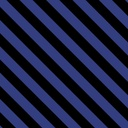


### Training Statistics
- **Step number**: 2996
- **Loss**: 1.1386338472366333
- **Learning Rate**: 0.000090


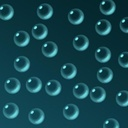


### Training Statistics
- **Step number**: 2996
- **Loss**: 2.3876280784606934
- **Learning Rate**: 0.000090


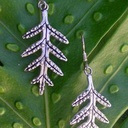


### Training Statistics
- **Step number**: 2996
- **Loss**: 4.91977596282959
- **Learning Rate**: 0.000090


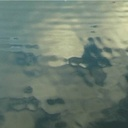


### Training Statistics
- **Step number**: 2996
- **Loss**: 2.279200553894043
- **Learning Rate**: 0.000090


In [12]:
# @title Training and Saving Models {vertical-output: true}
"""
This section trains the corresponding models using three different solvers
on 20 selected images. The trained models are then saved to the current
path.

Alternatively, you can upload pre-trained models, ignoring this section
and directly proceed to the next section.
"""

solver='euler'
num_fig=0
paths = ['data/textures/banded_0037.jpg', 'data/textures/bubbly_0101.jpg',
         'data/textures/bumpy_0081.jpg','data/textures/calm_water_4.jpg',
         'data/textures/chequered_0050.jpg','data/textures/cobwebbed_0059.jpg',
         'data/textures/cracked_0085.jpg','data/textures/crosshatched_0121.jpg',
         'data/textures/dotted_0201.jpg','data/textures/fibrous_0145.jpg',
         'data/textures/flames.jpg','data/textures/grid_0002.jpg',
         'data/textures/honeycombed_0061.jpg','data/textures/ink.jpg',
         'data/textures/interlaced_0081.jpg', 'data/textures/polka-dotted_0121.jpg',
         'data/textures/sea_2.jpg','data/textures/smoke_2.jpg',
         'data/textures/spiralled_0040.jpg','data/textures/woven_0121.jpg']
for image_path in paths:
  num_fig+=1
  if num_fig>4:
      continue
  #Define a pre-trained VGG model for loss calculations
  vgg = models.vgg16(weights='IMAGENET1K_V1').features
  if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at: {image_path}")
  style_img = imread(image_path, max_size=128)
  style_img_torch = torch.tensor(style_img).permute(2, 0, 1).unsqueeze(0)

  #Define loss function
  with torch.no_grad():
    loss_fn = RelaxedOTLoss(vgg, style_img_torch, n_samples=1024)
  imshow(style_img)

  #Define model and optimizer
  model = NoiseNCA()
  opt = torch.optim.Adam(model.parameters(), 1e-3, capturable=True)
  lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 2000], 0.3)
  loss_log = []

  #Define pool
  with torch.no_grad():
    pool = model.seed(256)

  #Start training
  for i in range(3000):

  #The pool technique mentioned in the report is used to
  #inhibit overfitting
    with torch.no_grad():
        batch_idx = np.random.choice(len(pool), 4, replace=False)
        s = pool[batch_idx]
        if i % 20 == 0:
            s[:1] = model.seed(1)

    step_n = np.random.randint(8, 32)
    for k in range(step_n):
        s = model(s, method = solver)

    overflow_loss = (s - s.clamp(-1.0, 1.0)).abs().sum()
    loss = loss_fn(to_rgb(s)) + overflow_loss
    with torch.no_grad():
        loss.backward()
        for p in model.parameters():
            p.grad /= (p.grad.norm() + 1e-8)  # normalize gradients
        opt.step()
        opt.zero_grad()
        lr_sched.step()
        pool[batch_idx] = s  # update pool

        loss_log.append(loss.item())
        if i % 5 == 0:
            if len(loss_log) == 1:
                display_id = display(Markdown(f'''
### Training Statistics
- **Step number**: {len(loss_log)}
- **Loss**: {loss.item()}
- **Learning Rate**: {lr_sched.get_last_lr()[0]:.6f}
'''), display_id=True)
            else:
    # 更新绑定区域的内容
                update_display(Markdown(f'''
### Training Statistics
- **Step number**: {len(loss_log)}
- **Loss**: {loss.item()}
- **Learning Rate**: {lr_sched.get_last_lr()[0]:.6f}
'''), display_id=display_id.display_id)
        '''
        if i % 50 == 0:
            pl.plot(loss_log, '.', alpha=0.1)
            pl.yscale('log')
            pl.ylim(np.min(loss_log), loss_log[0])
            pl.tight_layout()
            imshow(grab_plot(), id='log')
            imgs = to_rgb(s).permute([0, 2, 3, 1]).cpu()
            imshow(np.hstack(imgs), id='batch')
        '''
  torch.save(model, 'model_'+solver+'_'+str(num_fig)+'.pth')# save model

In [8]:
# @title Testing Models {vertical-output: true}
"""
This section tests different models using three different testing solvers.
The test results are saved to the 'result' folder.

The file names correspond to the different models
(trained with different training solvers),
and the file contents correspond to the test results
of using different testing solvers.

You need to first upload the pre-trained models
or execute the training section.
"""

paths = ['data/textures/banded_0037.jpg', 'data/textures/bubbly_0101.jpg',
         'data/textures/bumpy_0081.jpg','data/textures/calm_water_4.jpg',
         'data/textures/chequered_0050.jpg','data/textures/cobwebbed_0059.jpg',
         'data/textures/cracked_0085.jpg','data/textures/crosshatched_0121.jpg',
         'data/textures/dotted_0201.jpg','data/textures/fibrous_0145.jpg',
         'data/textures/flames.jpg','data/textures/grid_0002.jpg',
         'data/textures/honeycombed_0061.jpg','data/textures/ink.jpg',
         'data/textures/interlaced_0081.jpg', 'data/textures/polka-dotted_0121.jpg',
         'data/textures/sea_2.jpg','data/textures/smoke_2.jpg',
         'data/textures/spiralled_0040.jpg','data/textures/woven_0121.jpg']
if not os.path.exists('result'):
    os.mkdir('result')
for i in range(1, 3):
  data = np.zeros((3, 3))
  r=0
  c=0
  for M in ['euler', 'im_euler', 'rk4']: # Training Solver
    c = 0
    model = torch.load('model/model_'+M+'_'+str(i)+'.pth') # Load model
    model.eval()
    ss = model.seed(1, 128)
    vgg = models.vgg16(weights='IMAGENET1K_V1').features
    image_path = paths[i-1]
    style_img = imread(image_path, max_size=128)
    style_img_torch = torch.tensor(style_img).permute(2, 0, 1).unsqueeze(0)
    loss_fn = RelaxedOTLoss(vgg, style_img_torch, n_samples=1024)

    # Step size
    dt = 0.5 #@param {"type": "number"}
    dx = 1.0 #@param {"type": "number"}
    dy = 1.0 #@param {"type": "number"}
    height = 128 #@param {"type": "integer"}
    width = 128 #@param {"type": "integer"}
    #print(f"{M+'_'+str(i)}\n")
    for m in ['euler', 'im_euler', 'rk4']: # Testing Solver
      steps = int(1000/dt)
      loss_total = 0
      for cnt in range(10): # 10 runs per test
        with torch.no_grad():
          s = ss.clone()
          for step in range(steps):
            s[:] = model(s, method=m, dx=dx, dy=dy, dt=dt)
            if step >= 700/dt:
              overflow_loss = (s - s.clamp(-1.0, 1.0)).abs().sum()
              loss = loss_fn(to_rgb(s)) + overflow_loss
              loss_total += loss.item()
      result = (loss_total / 10) / (steps - 700 / dt) # report avg loss
      with open("result/output_"+M+'_'+str(i)+".txt", "a") as file:
        file.write(f"Test_Solver: {m}\n")
        file.write(f"Test_Result: Loss = {result}\n")
      #print(f"Test_Solver: {m}\n")
      #print(f"Test_Result: {result}\n")
      data[r, c] = result
      c += 1
    r += 1

In [9]:
# @title Testing Results Visualization {vertical-output: true}
"""
This section visualizes the dynamic texture effects.

You need to first upload the pre-trained models
or execute the training section.
"""

model = torch.load('model/model_euler_13.pth')
vgg = models.vgg16(weights='IMAGENET1K_V1').features
image_path = 'data/textures/honeycombed_0061.jpg'
style_img = imread(image_path, max_size=128)
style_img_torch = torch.tensor(style_img).permute(2, 0, 1).unsqueeze(0)
loss_fn = RelaxedOTLoss(vgg, style_img_torch, n_samples=1024)
dt = 1 #@param {"type": "number"}
dx = 1 #@param {"type": "number"}
dy = 1 #@param {"type": "number"}
height = 128 #@param {"type": "integer"}
width = 128 #@param {"type": "integer"}
with VideoWriter() as vid, torch.no_grad():
  s = model.seed(1, 128)
  steps = int(1000 / dt)
  for step in tqdm(range(steps)):
      s[:] = model(s, method='im_euler', dx=dx, dy=dy, dt=dt)

      if step % int(8 / dt) == 0:
          img = to_rgb(s[0]).permute(1, 2, 0).cpu()
          vid.add(zoom(img, 2))

  overflow_loss = (s - s.clamp(-1.0, 1.0)).abs().sum()
  loss = loss_fn(to_rgb(s)) + overflow_loss
  print(loss.item())
#Please check the generated video file in the directory.

  0%|          | 0/1000 [00:00<?, ?it/s]

3.85002064704895


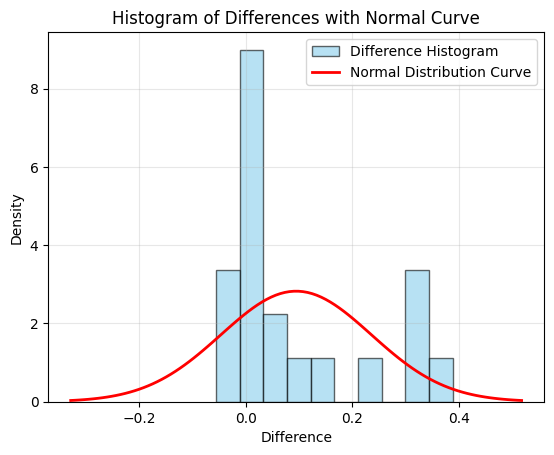

Array 1:
 [0.98396824 2.44692977 5.26676216 2.2901245  1.08732544 6.73746907
 2.27999635 3.08192044 6.17811456 3.58992351 3.96223919 6.77901619
 3.32413545 2.66902563 4.12408478 5.87311156 2.57529114 3.71458284
 6.75921193 5.78084977]
Array 2:
 [0.98353562 2.44317685 5.02820802 2.32421136 1.08703986 6.42251625
 2.21570416 3.07334674 5.7890339  3.64574607 3.92286565 6.76670752
 3.32421845 2.67615494 4.03111506 5.8471595  2.60074921 3.37100618
 6.42665933 5.6332079 ]
Wilcoxon Testing Results:
Statistic: 36.0
P-value: 0.00830841064453125


In [10]:
# @title Wilcoxoon Testing
'''
This is the loss value when the time step is 0.1.
Each row of the matrix represents the training solver,
and each column represents the testing solver.
Select the appropriate row and column to perform the paired test.
'''
import numpy as np
from scipy.stats import wilcoxon
from scipy.stats import shapiro, normaltest
import matplotlib.pyplot as plt
from scipy.stats import norm
data1 = np.array([
    [0.9644799198091031, 0.9646444006601969, 0.9642701627055803],
    [0.9808901094893614, 0.9839682409445445, 0.9835356185774008],
    [1.0028719045480092, 1.0093321409066518, 1.0086823776682217]
])
data2 =  np.array([[2.5762655195951463, 2.7988176671425498, 2.6534234908660252],
    [2.698995311752955, 2.446929765431086, 2.4431768461545307],
    [2.3923817136446637, 2.491852944946289, 2.491379386806488]])
data3 = np.array([[6.4570557624022165, 7.042353111187617, 6.876709792486826],
    [5.103150193246206, 5.266762162510554, 5.028208023166656],
    [4.888219741948445, 5.013086520433426, 5.157076426537832]     ])
data4 = np.array([
    [2.410320633093516, 2.3483530929962795, 2.412409202822049],
    [2.2843630070447922, 2.2901244974692663, 2.324211360549927],
    [2.374834549077352, 2.335987662601471, 2.308742308751742]
])
data5 = np.array([
    [0.8766375105818112, 0.8808092820088068, 0.8810388851900894],
    [1.0710876351853211, 1.0873254362265268, 1.0870398644646009],
    [1.5047675094922386, 0.8886171336770058, 0.8882918044149876]
])
data6 = np.array([
    [6.635859634923936, 6.841409479379654, 6.662854015922546],
    [6.987758854500452, 6.737469069099426, 6.422516250435511],
    [6.505025142606099, 6.47580297981898, 6.6098233869075775]
])
data7 = np.array([
    [2.2573003116289776, 2.2580362990140914, 2.197034466687838],
    [2.212336413192749, 2.2799963471889497, 2.215704160586993],
    [2.2063956566413245, 2.23296099088192, 2.226844518438975]
])
data8 = np.array([
    [5.251478582255046, 5.802405176830291, 5.8026594989458715],
    [3.069388192367554, 3.081920444639524, 3.073346741660436],
    [2.8641373484452566, 2.5505124296426773, 2.566477252189318]
])
data9 = np.array([
    [7.184561303933462, 9.377114856656393, 7.894459950399399],
    [5.8287629931132, 6.178114561621348, 5.789033901929855],
    [5.335396364323298, 5.074523271465302, 4.972138254674276]
])
data10 = np.array([
    [3.770748969475428, 3.761263026825587, 3.7538191453774767],
    [3.589595673354467, 3.5899235134681065, 3.6457460696617763],
    [3.6976583632071813, 3.7222859259764354, 3.7957765776554746]
])
data11 = np.array([
    [4.4128730707168575, 4.791679967387518, 4.468131020212174],
    [3.8192223017692566, 3.9622391937096917, 3.9228656470298766],
    [4.048327453112602, 3.9983070307890576, 3.92500227060318]
])
data12 = np.array([
    [6.001824989366532, 6.040912688573202, 5.974928222703935],
    [6.633597864182789, 6.779016189670562, 6.766707515239715],
    [6.673846974547704, 6.4207734008948005, 6.364987385892868]
])
data13 = np.array([
    [4.7405940236091615, 4.789443630115191, 4.79235719974041],
    [3.4128075686534247, 3.3241354461193082, 3.324218449266752],
    [3.4209715263764067, 3.607469583264987, 3.6793682791153586]
])
data14 = np.array([
    [2.6405667852242787, 2.637597382124265, 2.6399344207604725],
    [2.759001012070974, 2.6690256257057188, 2.676154936949412],
    [2.669111284104983, 2.7070750222285587, 2.6702438158194224]
])
data15 = np.array([
    [4.330807243712743, 4.450762791633606, 4.2119287532329555],
    [4.099721929073334, 4.124084780136744, 4.031115061791738],
    [4.083950176239013, 4.042803818996747, 4.030728761927286]
])
data16 = np.array([
    [6.532719847043356, 6.516222788763046, 6.517263612588247],
    [5.7357942638874055, 5.873111555910111, 5.8471594971974685],
    [6.247460001150767, 7.535081416161854, 7.629767591222127]
])
data17 = np.array([
    [2.6698445675611495, 2.7392175020376843, 2.7430571017344794],
    [2.5623834798812863, 2.5752911359151205, 2.600749210985502],
    [2.651567127362887, 2.5951659082730614, 2.5789904295841852]
])
data18 = np.array([
    [4.036841830094655, 4.12035326116085, 3.983902097876866],
    [3.063342517121633, 3.7145828421672182, 3.371006175049146],
    [2.3907026382843655, 2.3737203498363493, 2.3801430734395983]
])
data19 = np.array([
    [6.588339217583338, 6.73272114721934, 6.825129346021017],
    [7.089467677005133, 6.759211929019292, 6.426659329366683],
    [6.134122447745005, 6.401307598225276, 6.447388246107102]
])
data20 = np.array([
    [6.934343642377853, 6.981983644549052, 6.977667829211553],
    [5.5787516771316525, 5.780849774996439, 5.633207899936041],
    [5.510067602570851, 5.501308667023976, 5.657352258650462]
])
matrices = [data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11,
            data12, data13, data14, data15, data16, data17, data18, data19, data20]
array_1 = np.array([matrix[1, 1] for matrix in matrices])
array_2 = np.array([matrix[1, 2] for matrix in matrices])

"""
These codes test whether the differences follow a normal distribution.
In practice, most differences do not follow a normal distribution.
As a result, we do not use a paired t-test, but instead use the Wilcoxon signed-rank test.
"""
differences = array_1 - array_2
plt.hist(differences, bins=10, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Difference Histogram')
mean, std = np.mean(differences), np.std(differences)
x = np.linspace(mean - 3*std, mean + 3*std, 100)
pdf = norm.pdf(x, mean, std)
plt.plot(x, pdf, color='red', linewidth=2, label='Normal Distribution Curve')

plt.title("Histogram of Differences with Normal Curve")
plt.xlabel("Difference")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#the Wilcoxon signed-rank test
stat, p_value = wilcoxon(array_1, array_2)
print("Array 1:\n", array_1)
print("Array 2:\n", array_2)
print("Wilcoxon Testing Results:")
print("Statistic:", stat)
print("P-value:", p_value)

In [11]:
'''
This is the loss value when the time steps are 1.0 and 0.5.
Each row of the matrix represents the training solver,
and each column represents the testing solver.
Select the appropriate row, column, and corresponding time steps
to perform the paired test.
'''
#delta t =1.0
matrix_1 = np.array([[0.94562946, 0.95235707, 0.962871],
                     [np.nan, 1.0071686, 1.01044073],
                     [np.nan, np.nan, 0.99645383]])

matrix_2 = np.array([[2.57853863, 2.53029794, 2.6787397],
                     [np.nan, 2.48242307, 2.53828018],
                     [np.nan, np.nan, 2.15894708]])

matrix_3 = np.array([[4.82566731, 5.49103116, 6.41536875],
                     [np.nan, 4.93322773, 4.60880903],
                     [np.nan, np.nan, 5.50835329]])

matrix_4 = np.array([[2.41040823, 2.38141171, 2.41887592],
                     [np.nan, 2.28194809, 2.29559419],
                     [np.nan, np.nan, 2.30109849]])

matrix_5 = np.array([[0.92874256, 0.91262551, 0.87709282],
                     [np.nan, 0.88850078, 0.84871155],
                     [np.nan, np.nan, 0.90982185]])

matrix_6 = np.array([[6.77019622, 6.85437035, 6.92521313],
                     [np.nan, 6.48282327, 6.45792475],
                     [np.nan, 11.07473307, 6.97036072]])

matrix_7 = np.array([[2.14502622e+00, 2.23728510e+00, 2.21234575e+00],
                     [np.nan, 2.27530298e+00, 2.23255323e+00],
                     [np.nan, 4.56929521e+24, 2.26276607e+00]])

matrix_8 = np.array([[3.00188367, 5.6934668, 5.67353263],
                     [np.nan, 3.05065592, 3.13907211],
                     [np.nan, np.nan, 2.69554376]])

matrix_9 = np.array([[5.72743297, 5.28755927, 9.28243379],
                     [np.nan, 4.99762154, 5.26974905],
                     [np.nan, np.nan, 4.77196685]])

matrix_10 = np.array([[3.62847874, 3.69369683, 3.8243951],
                      [np.nan, 3.52445515, 3.58271811],
                      [np.nan, 3.6511511, 3.73561962]])

matrix_11 = np.array([[3.87781335, 4.34721457, 4.62715482],
                      [np.nan, 3.93772875, 4.12468375],
                      [np.nan, np.nan, 4.34109253]])

matrix_12 = np.array([[6.86336773, 6.32589735, 6.31589235],
                      [np.nan, 6.72151444, 6.35314209],
                      [np.nan, 10.50314669, 6.14575081]])

matrix_13 = np.array([[2.79442252, 3.59415575, 4.73849516],
                      [np.nan, 3.4409229, 3.82654527],
                      [np.nan, np.nan, 2.86663756]])

matrix_14 = np.array([[2.61156253, 2.66004069, 2.65488382],
                      [np.nan, 2.65734623, 2.69071059],
                      [np.nan, 2.67435584, 2.64244563]])

matrix_15 = np.array([[4.08674303, 4.29987104, 4.25070349],
                      [np.nan, 4.50916436, 4.21555195],
                      [np.nan, np.nan, 4.09840009]])

matrix_16 = np.array([[7.20220842, 6.92632419, 6.16216851],
                      [np.nan, 5.74879762, 6.19963234],
                      [np.nan, np.nan, 5.53048648]])

matrix_17 = np.array([[2.5591013, 2.71039476, 2.66762087],
                      [np.nan, 2.56580462, 2.55687195],
                      [np.nan, 2.78610371, 2.58007313]])

matrix_18 = np.array([[2.4410545, 3.98317707, 4.37894745],
                      [np.nan, 2.70123726, 4.38013785],
                      [np.nan, 2.45099443, 2.41587878]])

matrix_19 = np.array([[6.62021087, 6.53126404, 6.49652842],
                      [np.nan, 6.90831974, 6.74952001],
                      [np.nan, np.nan, 5.97267961]])

matrix_20 = np.array([[5.71518598, 6.08205219, 6.85475858],
                      [np.nan, 5.48946381, 5.38406521],
                      [np.nan, np.nan, 5.56237313]])
#delta t = 0.5
matrix_1b = np.array([[1.03565729, 1.13164405, 1.42493726],
                   [11.15019369, 0.97919971, 0.97774923],
                   [np.nan, 1.37587781, 1.0056506]])

matrix_2b = np.array([[2.90172534, 2.93636493, 3.26604917],
                   [5.46110533, 2.41393286, 2.6296593],
                   [np.nan, 2.39803022, 2.38180507]])

matrix_3b = np.array([[7.41075956, 7.43708628, 6.93596816],
                   [np.nan, 4.78324224, 4.80507284],
                   [5.21253094, 5.03487144, 5.15915966]])

matrix_4b = np.array([[2.42742082, 2.42839688, 2.48286577],
                   [np.nan, 2.33303259, 2.25072278],
                   [np.nan, 2.29388841, 2.26261584]])

matrix_5b = np.array([[0.87531937, 0.90445632, 0.93121336],
                   [1.21876098, 0.92664492, 0.86314268],
                   [np.nan, 1.57894392, 0.85615304]])

matrix_6b = np.array([[6.93362086e+00, 7.09032332e+00, 7.12166161e+00],
                   [np.nan, 6.50925432e+00, 6.98468963e+00],
                   [1.29341312e+28, 6.62347653e+00, 6.19998180e+00]])

matrix_7b = np.array([[2.31019895, 2.20843644, 2.24908701],
                   [np.nan, 2.30213899, 2.21361069],
                   [np.nan, 2.22865542, 2.23918625]])

matrix_8b = np.array([[3.9727314, 6.15503271, 6.17044623],
                   [np.nan, 3.08667876, 3.09785418],
                   [np.nan, 3.79545258, 3.90223792]])

matrix_9b = np.array([[7.48217681, 8.02335631, 7.29921637],
                   [8.20868139, 5.55757691, 5.50603982],
                   [np.nan, 5.28445987, 5.04743851]])

matrix_10b = np.array([[3.64357924, 3.80965152, 3.72147815],
                    [5.25426757, 3.54376431, 3.57643973],
                    [4.14432658, 3.83792307, 3.71198244]])

matrix_11b = np.array([[4.30872786, 4.63316304, 4.51032542],
                    [4.12634613, 3.86836368, 3.91056231],
                    [np.nan, 4.09039887, 4.08823833]])

matrix_12b = np.array([[6.11212523, 6.10819877, 6.18988439],
                    [56.63559336, 7.3152852, 6.82972036],
                    [6.49951881, 6.81007864, 7.31136687]])

matrix_13b = np.array([[4.43594522e+00, 4.73537720e+00, 4.83458836e+00],
                    [5.02719252e+15, 3.46724601e+00, 3.17343245e+00],
                    [np.nan, 3.69728818e+00, 3.04001845e+00]])

matrix_14b = np.array([[2.6539627, 2.64256787, 2.6337442],
                    [np.nan, 2.63396642, 2.66840902],
                    [2.67864204, 2.65194339, 2.64043315]])

matrix_15b = np.array([[4.24786957e+00, 4.30857767e+00, 4.30052895e+00],
                    [7.03324448e+00, 4.31085139e+00, 4.22563974e+00],
                    [1.19284141e+28, 4.31975008e+00, 4.12782809e+00]])

matrix_16b = np.array([[6.39465359e+00, 6.36451959e+00, 6.56129977e+00],
                    [7.74676539e+22, 5.83096644e+00, 5.69544581e+00],
                    [np.nan, 6.69219064e+00, 6.20010651e+00]])

matrix_17b = np.array([[2.56763098e+00, 2.68700475e+00, 2.67721627e+00],
                    [8.80824813e+07, 2.56500924e+00, 2.53786965e+00],
                    [np.nan, 2.59871511e+00, 2.53563032e+00]])

matrix_18b = np.array([[3.69666148, 4.94066104, 4.47023797],
                    [np.nan, 3.21203645, 3.2230329],
                    [2.48181211, 2.44929156, 2.46565217]])

matrix_19b = np.array([[6.85582479, 6.55158286, 6.48515125],
                    [7.244494, 6.55666437, 6.08669422],
                    [np.nan, 6.32216225, 6.22035083]])

matrix_20b = np.array([[7.06829433e+00, 7.08573139e+00, 7.27489884e+00],
                    [1.74386586e+30, 6.40242328e+00, 6.44102467e+00],
                    [np.nan, 5.80273544e+00, 5.74194123e+00]])
# Define a list containing the 20 matrices
matrices_a = [
    matrix_1, matrix_2, matrix_3, matrix_4, matrix_5,
    matrix_6, matrix_7, matrix_8, matrix_9, matrix_10,
    matrix_11, matrix_12, matrix_13, matrix_14, matrix_15,
    matrix_16, matrix_17, matrix_18, matrix_19, matrix_20
]
matrices_b = [
    matrix_1b, matrix_2b, matrix_3b, matrix_4b, matrix_5b,
    matrix_6b, matrix_7b, matrix_8b, matrix_9b, matrix_10b,
    matrix_11b, matrix_12b, matrix_13b, matrix_14b, matrix_15b,
    matrix_16b, matrix_17b, matrix_18b, matrix_19b, matrix_20b
]
array_1 = np.array([matrix[0, 2] for matrix in matrices_a])
array_2 = np.array([matrix[0, 2] for matrix in matrices_b])
array_3 = np.array([matrix[0, 2] for matrix in matrices])
stat, p_value = wilcoxon(array_2, array_3)

print("Array 1:\n", array_2)
print("Array 2:\n", array_3)
print("Wilcoxon Testing Results:")
print("Statistic:", stat)
print("P-value:", p_value)

Array 1:
 [1.42493726 3.26604917 6.93596816 2.48286577 0.93121336 7.12166161
 2.24908701 6.17044623 7.29921637 3.72147815 4.51032542 6.18988439
 4.83458836 2.6337442  4.30052895 6.56129977 2.67721627 4.47023797
 6.48515125 7.27489884]
Array 2:
 [0.96427016 2.65342349 6.87670979 2.4124092  0.88103889 6.66285402
 2.19703447 5.8026595  7.89445995 3.75381915 4.46813102 5.97492822
 4.7923572  2.63993442 4.21192875 6.51726361 2.7430571  3.9839021
 6.82512935 6.97766783]
Wilcoxon Testing Results:
Statistic: 45.0
P-value: 0.023950576782226562
